BIDV

In [1]:
#. Import thư viện cần thiết
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/BIDV.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)


In [3]:
df1=df.reset_index()['Price']

In [4]:
#. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
#. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [6]:
#. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:
# . Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [9]:
# . Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# . Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1264
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0138
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0069
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0052
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0041
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0030
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0023
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0017
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0016
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0014
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0013
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0013
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0013
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0013
E

In [11]:
# . Dự báo dữ liệu test

y_pred=model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [12]:
# . Chuẩn hóa dữ liệu y_pred

y_pred=scaler.inverse_transform(y_pred)

In [13]:
# Chuẩn hóa dữu liệuu y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [14]:
# Tính RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#Tinh Mae
mae = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print('Testing Mae:', mae)

Testing RMSE: 516.2886351424108
Testing MAPE: 1.5551805088598107
Testing Mae: 412.41447147651


In [15]:
#. Dự báo 30 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_30 = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i = i + 1

next_30_days = scaler.inverse_transform(lst_output_30)    

In [16]:
#. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0

while i < 60:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1

next_60_days = scaler.inverse_transform(lst_output_60)        

In [17]:
# 12. Dự báo 90 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

next_90_days = scaler.inverse_transform(lst_output_90)        

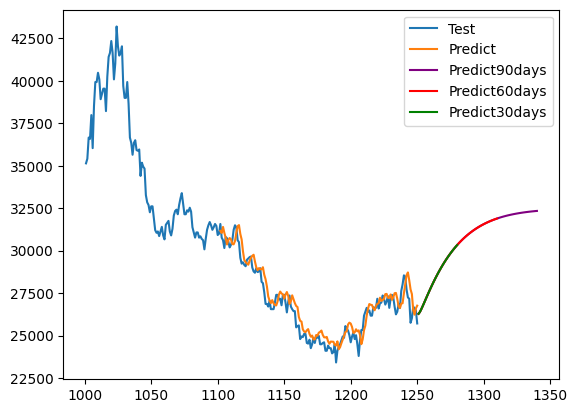

In [18]:
# Vẽ hình dự báo 30 ngày tiếp theo

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

predict_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,next_90_days, color='purple')
predict_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,next_60_days, color='red')
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,next_30_days, color='green')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])

plt.show()

VIB


In [19]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/VIB.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [20]:
df1=df.reset_index()['Price']

In [21]:
#. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [22]:
#. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [23]:
#. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [24]:
#. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [25]:
# . Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [26]:
# . Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# . Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1367
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0181
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0074
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0039
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0023
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0012
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.8126e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 9.1150e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.6997e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.2082e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.3286e-04
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.3378e-04
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.4734e-04
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.4560e-04
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━

In [28]:
# . Dự báo dữ liệu test

y_pred=model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [29]:
# . Chuẩn hóa dữ liệu y_pred
y_pred=scaler.inverse_transform(y_pred)

In [30]:
# Chuẩn hóa dữu liệuu y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [31]:
# Tính RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#Tinh Mae
mae = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print('Testing Mae:', mae)

Testing RMSE: 375.97720281388456
Testing MAPE: 1.7866294813476113
Testing Mae: 188.4347880595439


In [32]:
#. Dự báo 30 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_30 = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i = i + 1

next_30_days = scaler.inverse_transform(lst_output_30)    

In [33]:
#. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0

while i < 60:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1

next_60_days = scaler.inverse_transform(lst_output_60)        

In [34]:
# 12. Dự báo 90 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

next_90_days = scaler.inverse_transform(lst_output_90)        

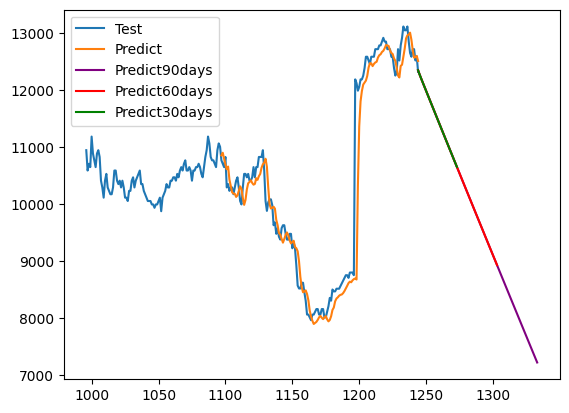

In [35]:
# Vẽ hình dự báo 

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

predict_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,next_90_days, color='purple')
predict_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,next_60_days, color='red')
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,next_30_days, color='green')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])

plt.show()

STB


In [36]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/STB.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [37]:
df1=df.reset_index()['Price']

In [38]:
#. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [39]:
#. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [40]:
#. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [41]:
#. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [42]:
# . Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [43]:
# . Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
# . Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1628
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0235
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0083
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0045
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0028
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0016
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0012
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.2909e-04
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.0000e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.5751e-04
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.7056e-04
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.4692e-04
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 8.0831e-04
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.6562e-04
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0

In [45]:
# . Dự báo dữ liệu test

y_pred=model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [46]:
# . Chuẩn hóa dữ liệu y_pred

y_pred=scaler.inverse_transform(y_pred)

In [47]:
# Chuẩn hóa dữu liệuu y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [48]:
# Tính RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#Tinh Mae
mae = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print('Testing Mae:', mae)

Testing RMSE: 141.9439503156164
Testing MAPE: 0.9841378107631219
Testing Mae: 111.8474334102349


In [49]:
#. Dự báo 30 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_30 = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i = i + 1

next_30_days = scaler.inverse_transform(lst_output_30)    

In [50]:
#. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0

while i < 60:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1

next_60_days = scaler.inverse_transform(lst_output_60)        

In [51]:
# 12. Dự báo 90 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

next_90_days = scaler.inverse_transform(lst_output_90)        

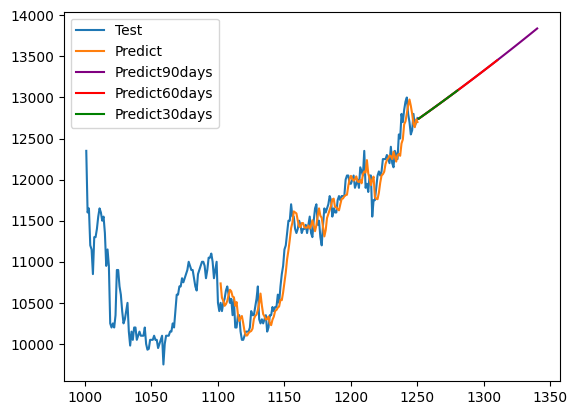

In [52]:
#Vẽ hình dự báo 

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

predict_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,next_90_days, color='purple')
predict_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,next_60_days, color='red')
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,next_30_days, color='green')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])

plt.show()